In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
data = np.load("../data/mnist_rot_train.npz")
X_tr = torch.from_numpy(data["X"]).float()
y_tr = torch.from_numpy(data["labels"])
a_tr = torch.from_numpy(data["angles"])

# data = np.load("../data/mnist_rot_validation.npz")
# X_val = torch.from_numpy(data["X"]).float()
# y_val = torch.from_numpy(data["labels"])
# a_val = torch.from_numpy(data["angles"])

In [3]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.linear1 = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 64),
            nn.ReLU(inplace=True)
        )

        # Classification branch
        self.linear2 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 10)
        )

        # Angle branch
        self.linear3 = nn.Sequential(
            nn.Linear(64, 32),
            nn.ReLU(inplace=True),
            nn.Linear(32, 1)
        )

    def forward(self, X):
        h1 = self.linear1(X)

        h2 = self.linear2(h1)
        h3 = self.linear3(h1).view(-1)

        return h2, h3

    def predict(self, X):
        y_pred, a_pred = self.forward(X)
        y_pred = torch.argmax(y_pred, dim=1)

        return y_pred, a_pred

In [4]:
def calculate_error(y_pred, y, a_pred, a):
    class_err = (y_pred != y).float().mean().item()
    angle_err = torch.abs(a_pred - a).mean().item()

    return class_err, angle_err


class_errs, angle_errs = [], []


def train(alpha=0.5):
    model = Net()
    epochs = 20

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-4)
    dataset = TensorDataset(X_tr, y_tr, a_tr)
    train_loader = DataLoader(dataset, batch_size=64, shuffle=True)

    for i in range(epochs):
        loss = None
        for X_batch, y_batch, a_batch in train_loader:
            y_pred, a_pred = model.forward(X_batch)

            ce_loss = F.cross_entropy(y_pred, y_batch, reduction='sum')
            a_loss = 0.5 * (1 - torch.cos(0.01745 * (a_batch - a_pred))).sum()
            loss = (alpha * ce_loss) + (1 - alpha) * a_loss

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if i % 5 == 0:
            print('Loss', loss.item())
    # Predict
    y_pred, a_pred = model.predict(X_tr)
    errors = calculate_error(y_pred, y_tr, a_pred, a_tr)
    print(errors)

    return errors

In [5]:
train(0.5)

# for i in range(11):
#     alpha = 0.1 * i
#     cls_err, a_mae = train(alpha)

#     print('a', alpha, cls_err, a_mae)

#     class_errs.append(cls_err)
#     angle_errs.append(a_mae)

Loss 5.85087163412249
Loss 1.2046803334160567
Loss 3.694387439287747
Loss 0.18705142907837752
(0.001366666634567082, 8.032745479059994)


(0.001366666634567082, 8.032745479059994)

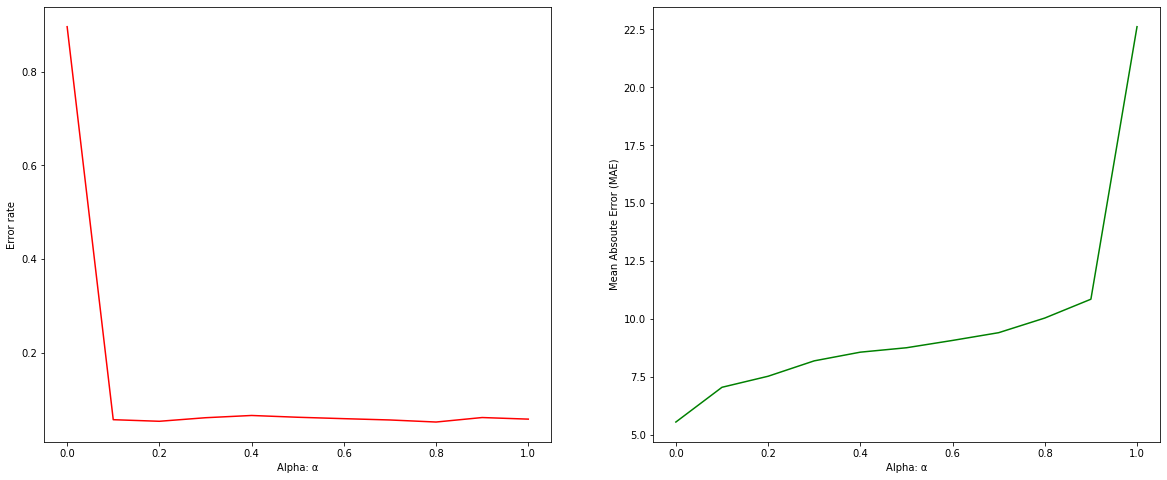

In [28]:
plt.rcParams["figure.figsize"] = (20, 8)

plt.subplot(1, 2, 1)
plt.ylabel('Error rate')
plt.xlabel('Alpha: α')
plt.plot(np.linspace(0, 1, 11), class_errs, '-r')

plt.subplot(1, 2, 2)
plt.ylabel('Mean Absoute Error (MAE)')
plt.xlabel('Alpha: α')
plt.plot(np.linspace(0, 1, 11), angle_errs, '-g')

In [37]:
from nn import NN

dimens = [
    (784, 256),
    (256,),
    (256, 64),
    (64,),
    (64, 32),
    (32,),
    (64, 32),
    (32,),
    (32, 10),
    (10,),
    (32, 1),
    (1,),
]

model = NN(0.5, 20)

params = [np.random.rand(*dimen) for dimen in dimens]
model.set_params(params)